In [22]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import pandas as pd
import torch
from segmentation_models_pytorch.losses import FocalLoss
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
dataset_path = "content/my-datasets"

# Rutas de las carpetas
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
valid_path = os.path.join(dataset_path, "valid")

# Obtener listas de archivos
def get_image_mask_paths(folder):
    # Filtrar solo imágenes originales (sin _mask)
    image_files = sorted([f for f in os.listdir(folder) if f.endswith((".jpg", ".png")) and "_mask" not in f])

    # Generar nombres de las máscaras correctamente
    mask_files = [img.rsplit(".", 1)[0] + "_mask.png" for img in image_files]

    return image_files, mask_files

train_images, train_masks = get_image_mask_paths(train_path)
test_images, test_masks = get_image_mask_paths(test_path)
valid_images, valid_masks = get_image_mask_paths(valid_path)

print(f"Entrenamiento: {len(train_images)} imágenes")
print(f"Validación: {len(valid_images)} imágenes")
print(f"Prueba: {len(test_images)} imágenes")

Entrenamiento: 225 imágenes
Validación: 22 imágenes
Prueba: 10 imágenes


In [24]:
# Leer el archivo CSV
classes_csv = "content/my-datasets/train/_classes.csv"
classes_df = pd.read_csv(classes_csv)

# Obtener el número de clases
num_classes = len(classes_df)
print(f"Número de clases en segmentación: {num_classes}")
print(classes_df)

Número de clases en segmentación: 5
   Pixel Value              Class
0            0         background
1            1               agua
2            2     suelo expuesto
3            3    vegetacion seca
4            4   vegetacion verde


In [25]:
class SoilDataset(Dataset):
    def __init__(self, folder, image_files, mask_files, transform=None):
        self.folder = folder
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.image_files[idx])
        mask_path = os.path.join(self.folder, self.mask_files[idx])

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Imagen no encontrada: {img_path}")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Máscara no encontrada: {mask_path}")

        # Cargar imagen y máscara
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Mantener valores originales

        if mask is None:
            raise ValueError(f"Error al cargar la máscara: {mask_path}")

        # Convertir máscara a `int64` antes de las transformaciones
        mask = mask.astype(np.int64)

        # Aplicar transformaciones de Albumentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)  # Ahora no convertimos a numpy
            image, mask = augmented["image"], augmented["mask"]

        # Asegurar que la máscara es `torch.LongTensor`
        mask = mask.long()

        return image, mask

In [26]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.5),
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [27]:
train_dataset = SoilDataset("content/my-datasets/train", train_images, train_masks, transform)
valid_dataset = SoilDataset("content/my-datasets/valid", valid_images, valid_masks, transform)
test_dataset = SoilDataset("content/my-datasets/test", test_images, test_masks, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
class_labels = ["Agua", "Suelo Expuesto", "Vegetación Seca", "Vegetación Verde"]

In [29]:
def compute_dice(preds, masks, num_classes=5):
    preds = torch.argmax(preds, dim=1)  # Convertir logits a clases
    dice_per_class = []

    for cls in range(num_classes):
        intersection = ((preds == cls) & (masks == cls)).sum().float()
        dice = (2. * intersection + 1e-6) / ((preds == cls).sum().float() + (masks == cls).sum().float() + 1e-6)
        dice_per_class.append(dice.item())

    return sum(dice_per_class) / num_classes  # Promedio del F1 Score (Dice)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
model = torch.load("../models/clasificacion.pth", map_location=torch.device(device), weights_only=False)
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [32]:
model.eval()
dice_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # Calcular F1 Score (Dice)
        dice_scores.append(compute_dice(outputs, masks, num_classes=5))

# Promediar los valores obtenidos
final_dice_score = sum(dice_scores) / len(dice_scores)
print(f"F1 Score (Dice Score): {final_dice_score:.4f}")

F1 Score (Dice Score): 0.5773


In [33]:
def generate_confusion_report(model, test_loader, num_classes=5, class_labels=None, device="cuda"):
    model.eval()

    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Convertir logits a clases

            all_preds.extend(preds.cpu().numpy().flatten())
            all_masks.extend(masks.cpu().numpy().flatten())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_masks, all_preds, labels=list(range(num_classes)))

    # Generar reporte de clasificación
    report = classification_report(all_masks, all_preds, target_names=class_labels, digits=4)

    return cm, report

In [34]:
print(f"num_classes: {num_classes}")
print(f"class_labels: {class_labels} (len: {len(class_labels)})")

num_classes: 5
class_labels: ['Agua', 'Suelo Expuesto', 'Vegetación Seca', 'Vegetación Verde', 'Background'] (len: 5)


In [35]:
# Generar reporte de matriz de confusión y clasificación
cm, report = generate_confusion_report(model, test_loader, num_classes=4, class_labels=class_labels, device=device)

/home/jose/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jose/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jose/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jose/.local/lib/python3.13/sit

In [36]:
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
                  precision    recall  f1-score   support

            Agua     0.0000    0.0000    0.0000      8144
  Suelo Expuesto     0.0000    0.0000    0.0000         0
 Vegetación Seca     0.6876    0.9432    0.7954    207040
Vegetación Verde     0.9018    0.7597    0.8247    398948
      Background     0.6595    0.5015    0.5697     41228

        accuracy                         0.7920    655360
       macro avg     0.4498    0.4409    0.4380    655360
    weighted avg     0.8077    0.7920    0.7891    655360



Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


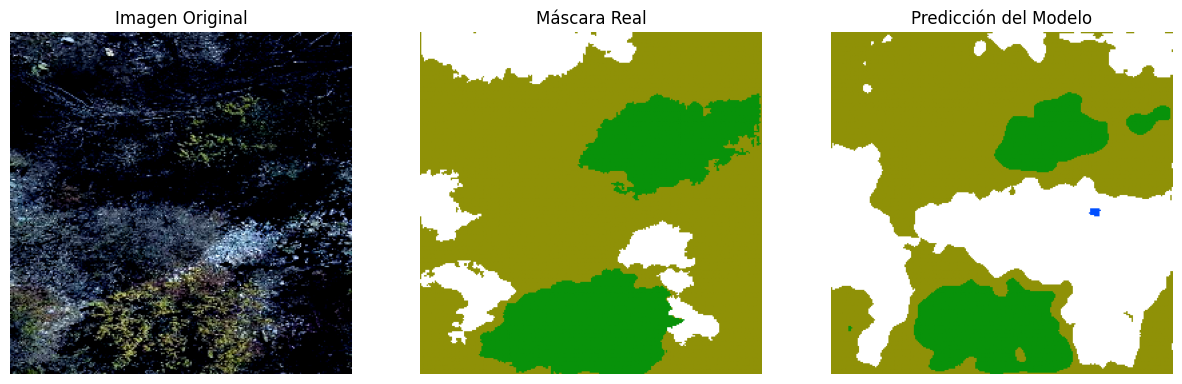

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


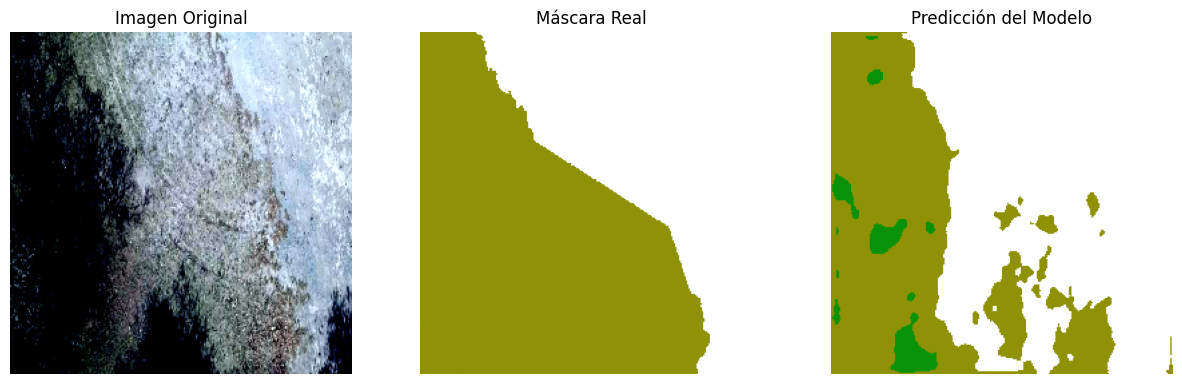

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


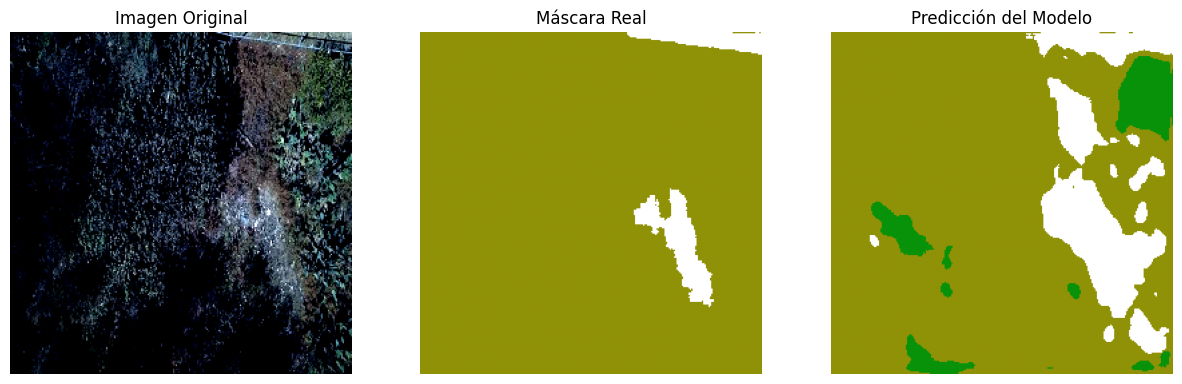

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


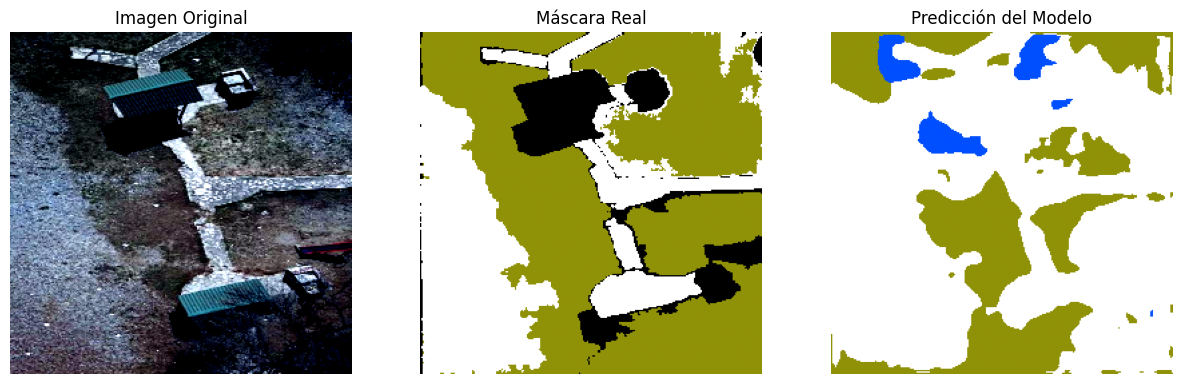

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


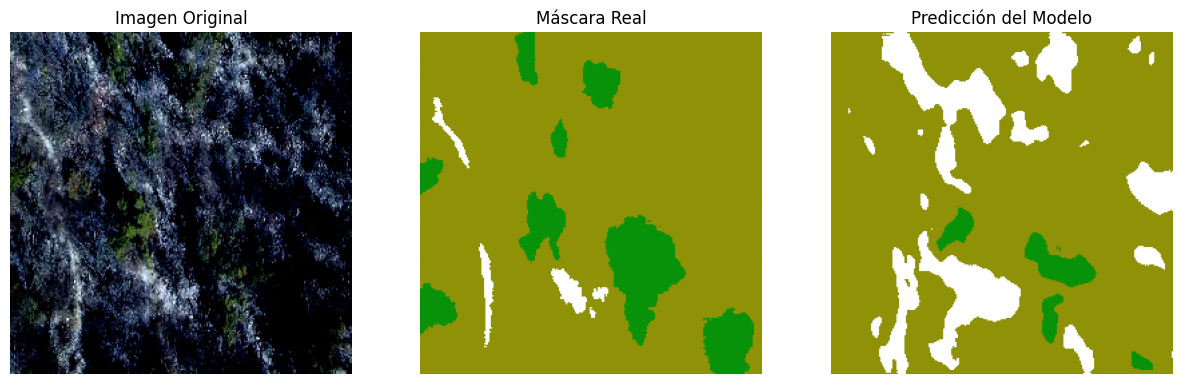

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


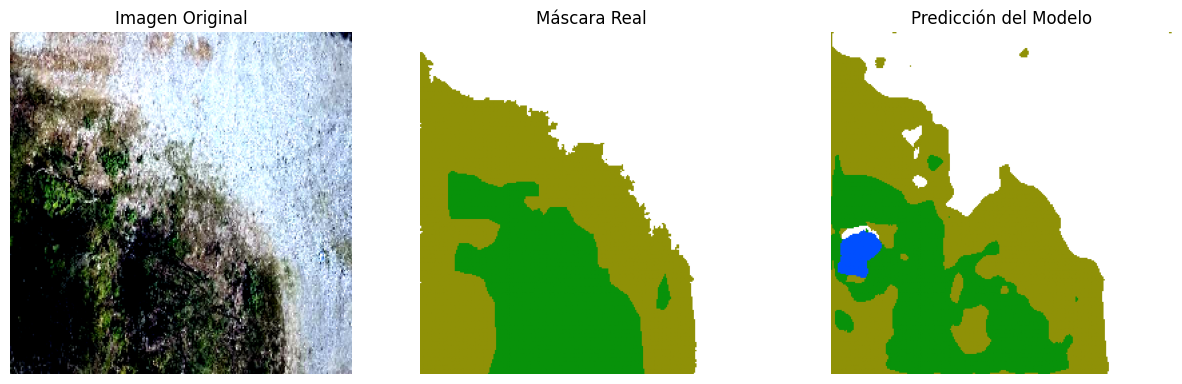

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


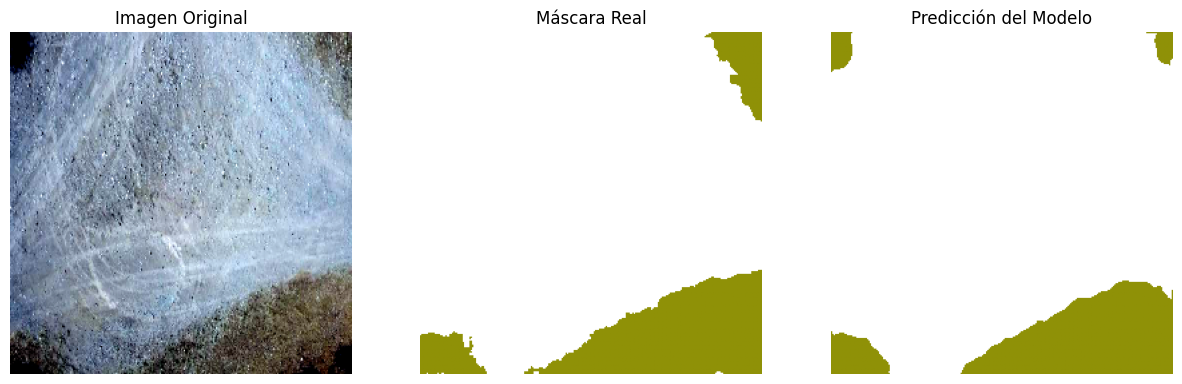

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


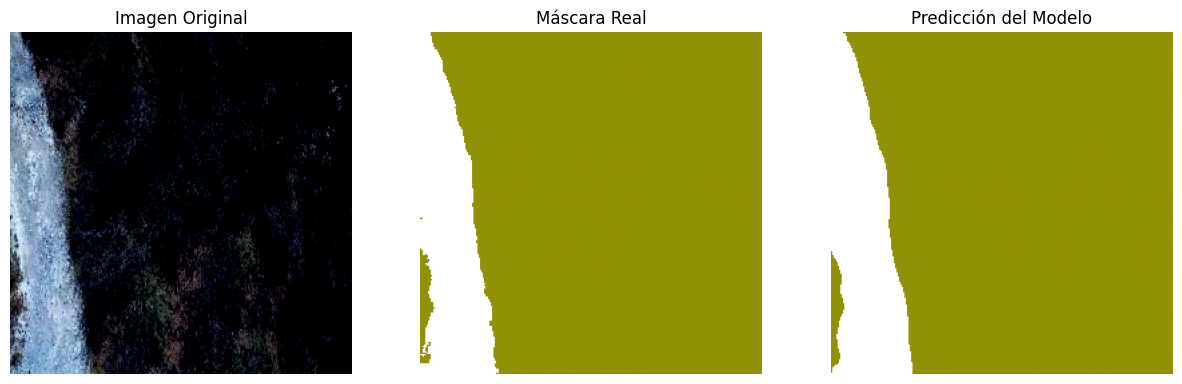

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


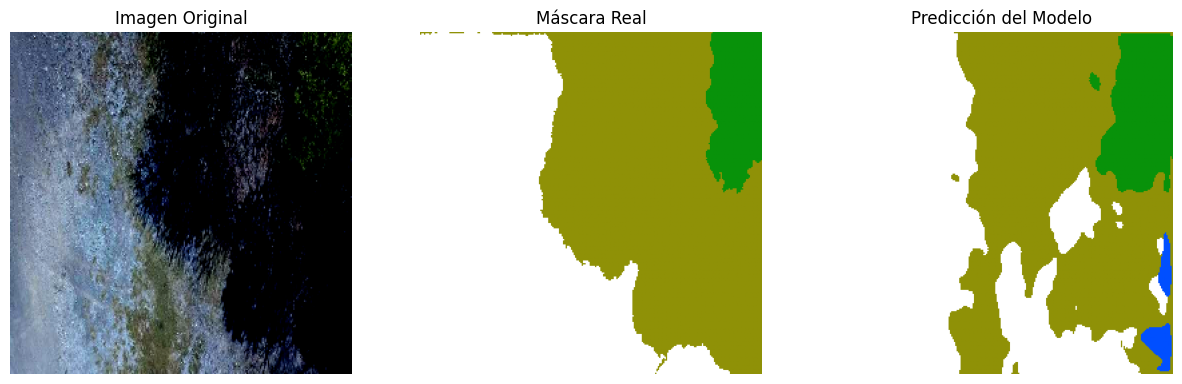

Shape de la imagen antes de desnormalizar: torch.Size([3, 256, 256])
Forma después de desnormalización: torch.Size([3, 256, 256])


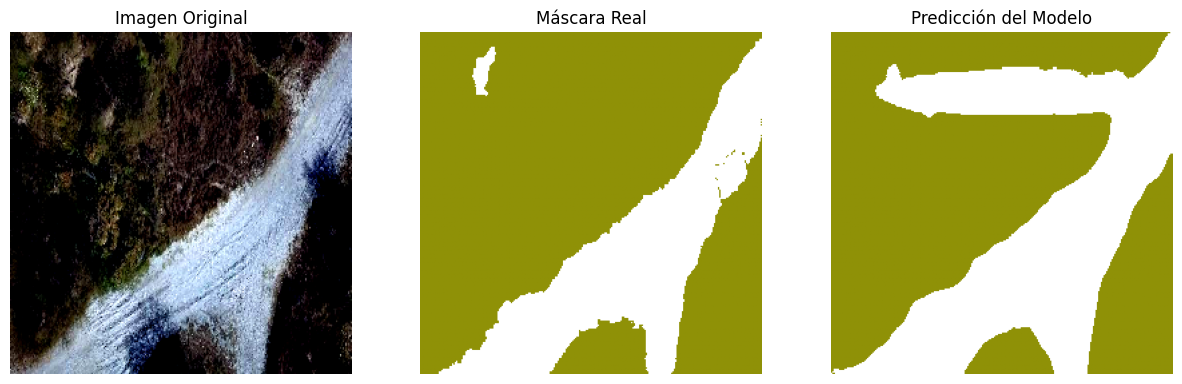

In [37]:
from matplotlib.colors import ListedColormap

# Definir colores personalizados para cada clase
custom_colors = [
    "#000000",  # 0 - Background (Negro)
    "#004fff",  # 1 - Agua (Azul)
    "#FFFFFF",  # 2 - Suelo Expuesto (Blanco)
    "#8f9107",  # 3 - Vegetación Seca (Amarillo)
    "#08920a",  # 4 - Vegetación Verde (Verde)
]

# Crear un colormap personalizado
custom_cmap = ListedColormap(custom_colors)

# Definir el número máximo de imágenes a mostrar
num_images_to_show = 10
total_count = 0

# Definir los valores de normalización (deben coincidir con los usados en transforms.Normalize)
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # Convertir a (3, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)   # Convertir a (3, 1, 1)

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # Seleccionar la clase más probable

        batch_size = images.shape[0]
        
        for i in range(batch_size):
            if total_count >= num_images_to_show:
                break  

            # **Revisar la forma de la imagen antes de desnormalizar**
            print(f"Shape de la imagen antes de desnormalizar: {images[i].shape}")

            # **Obtener la imagen**
            image_np = images[i].cpu()

            # **Desnormalizar correctamente**
            image_np = (image_np * std + mean)  # Evita que la forma cambie
            image_np = torch.clamp(image_np, 0, 1)  # Asegurar valores en [0,1]

            # **Imprimir forma después de desnormalizar**
            print("Forma después de desnormalización:", image_np.shape)

            # **Aplicar permute()**
            image_np = image_np.permute(1, 2, 0).numpy()  # (C, H, W) ? (H, W, C)

            # Convertir máscara y predicción a NumPy
            mask_np = masks[i].cpu().numpy()
            pred_np = preds[i].cpu().numpy()

            # Mostrar las imágenes
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(image_np)  # Imagen corregida
            plt.title("Imagen Original")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(mask_np, cmap=custom_cmap, vmin=0, vmax=len(custom_colors)-1)
            plt.title("Máscara Real")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_np, cmap=custom_cmap, vmin=0, vmax=len(custom_colors)-1)
            plt.title("Predicción del Modelo")
            plt.axis("off")

            plt.show()
            total_count += 1  

        if total_count >= num_images_to_show:
            break